# Convolutional Neural Network in Music Classification

## Introduction

This notebook delineates the process to build a CNN in order to classify the music scraped and downloaded in the `spotify_scraping` notebook. We have already seen how Spotify's pre-extracted features can be used to classify different music genres. However, as we saw, they were not the best at classifying niche music genres in different languages. The custom extracted features such as Zero-Crossing-Rate and Spectroids allowed for better classification of music. However, in some genres, the accuracy grew worse overall as different genres confounded the classification, especially pop.

A CNN is one of the most successful machine learning method utilized to predict images. Audio files and signals can be turned into images by extracting their mfccs at different frequencies, thus building a 2-D image that can be fed into CNNs. 

In this notebook, we will build a CNN in order to classify the previews of all the music we have previously downloaded. The process is 

1. Preprocessing the dataset to extract the mfccs
2. Building a 3-layered CNN with one drop-out in the third layer
3. Tuning the hyperparameters `Filters`, `Learning-Rate` and `Epochs` in order to best classify the music genres.
4. Running the final model
5. Comparing the accuracy.

In [5]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 35.4 MB/s 


In [72]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import datetime
import pandas as pd

In [ ]:
%load_ext tensorboard

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining Sample Rate and Slices

In order to extract audio signals from the music files, we'll have to pre-process the data and extract the relevant mfccs. The sample rate determines how many samples are taken per second from a continuous signal to turn it into a digital one. We're using the default 22k rate. The number of slices is how many times we will divide our 30 second audio, and the number of samples per slice is a simple division of the two

In [8]:
#Dataset location
SOURCE_PATH = 'drive/MyDrive/music/'

# Path to labels and processed data file, json format.
JSON_PATH = 'drive/MyDrive/data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples, pick a duration right under 30 seconds.
TOTAL_SAMPLES = 10 * sr

# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

## Preprocessing

The function below takes an audio file and uses the librosa library to extract 13 mfccs which is the industry standard. The data will be 3-dimensional i.e. there will be 13 mfccs per sample size so one audio file will have multiple mfccs at every slice. Thus, the data cannot be stores in a `csv` and will be storing it in a `json` format instead.

In [ ]:
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())

    # Let's write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

## Loading, Predicting & Plotting Functions

To extract the data fromt the `json` file, we've defined a function that automatically separates the labels from the mfccs.

In order to plot the validation and training accuracy, we will define a function that plots the performance over epochs.

We have also defined a function that allows us to test one single prediction. Since we cannot compare audio files, we will just compare labels.

In [53]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

def plot_performance(hist):
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "Blues",
        1 : "Classical",
        2 : "EDM",
        3 : "Ghazal",
        4 : "Hip-Hop",
        5 : "Metal",
        6 : "Pop",
        7 : "Qawwali",
        8 : "Rap",
        9 : "Rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

The cell below preprocesses the approximately 3000 songs and extracts the relevant data from them. This is a time-consuming process, therefore it is recommended to use the data.json file instead.

In [ ]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

## Hyperparameter Tuning

The next few code sections create a 3-layer CNN with one final dense layer and a flattening layer. The hyperparamters to be tuned are the `filters`, `epochs` and `learning-rate`. We will be using the `Adam` algorithm to calculate gradient descent

In [42]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Conv layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('filters', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Conv2D(filters=hp_units, kernel_size = (3,3), activation='relu', input_shape = (inputs_train.shape[1], inputs_train.shape[2], 1)))
  model.add(tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(filters=hp_units,kernel_size = (3,3),activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  
  hp_dropout = hp.Int
  model.add(tf.keras.layers.Conv2D(filters = hp_units,kernel_size = (2,2),activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.3))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [43]:
inputs, targets = load_data(json_path=JSON_PATH)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

(38140, 44, 13)


In [44]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='drive/MyDrive/my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [45]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('filters')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.5281009078025818

Best val_accuracy So Far: 0.6128133535385132
Total elapsed time: 00h 17m 10s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



In [46]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
763/763 [==============================] - 10s 12ms/step - loss: 1.5119 - accuracy: 0.4573 - val_loss: 1.2227 - val_accuracy: 0.5286
Epoch 2/50
763/763 [==============================] - 8s 11ms/step - loss: 1.2675 - accuracy: 0.5182 - val_loss: 1.1226 - val_accuracy: 0.5633
Epoch 3/50
763/763 [==============================] - 9s 12ms/step - loss: 1.1886 - accuracy: 0.5426 - val_loss: 1.0958 - val_accuracy: 0.5632
Epoch 4/50
763/763 [==============================] - 9s 12ms/step - loss: 1.1192 - accuracy: 0.5637 - val_loss: 1.1223 - val_accuracy: 0.5532
Epoch 5/50
763/763 [==============================] - 8s 11ms/step - loss: 1.0613 - accuracy: 0.5819 - val_loss: 1.0420 - val_accuracy: 0.5832
Epoch 6/50
763/763 [==============================] - 9s 12ms/step - loss: 1.0179 - accuracy: 0.5970 - val_loss: 1.0430 - val_accuracy: 0.5902
Epoch 7/50
763/763 [==============================] - 8s 11ms/step - loss: 0.9587 - accuracy: 0.6208 - val_loss: 1.0177 - val_accuracy: 0.591

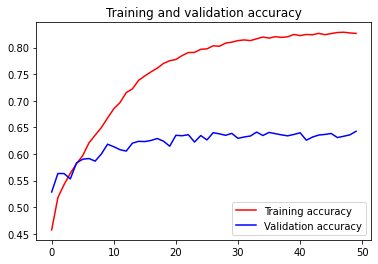

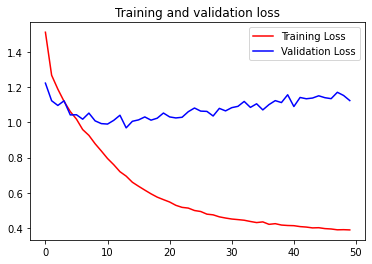

In [54]:
plot_performance(history)

In [ ]:
log_dir = "drive/MyDrive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [56]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, callback = [tensorboard_callback])

Epoch 1/50
763/763 [==============================] - 10s 12ms/step - loss: 1.4799 - accuracy: 0.4638 - val_loss: 1.2226 - val_accuracy: 0.5266
Epoch 2/50
763/763 [==============================] - 9s 11ms/step - loss: 1.2665 - accuracy: 0.5141 - val_loss: 1.1525 - val_accuracy: 0.5428
Epoch 3/50
763/763 [==============================] - 8s 11ms/step - loss: 1.1842 - accuracy: 0.5382 - val_loss: 1.1501 - val_accuracy: 0.5445
Epoch 4/50
763/763 [==============================] - 8s 11ms/step - loss: 1.1257 - accuracy: 0.5596 - val_loss: 1.1237 - val_accuracy: 0.5579
Epoch 5/50
763/763 [==============================] - 9s 12ms/step - loss: 1.0704 - accuracy: 0.5761 - val_loss: 1.0618 - val_accuracy: 0.5814
Epoch 6/50
763/763 [==============================] - 8s 11ms/step - loss: 1.0213 - accuracy: 0.5939 - val_loss: 1.0178 - val_accuracy: 0.5935
Epoch 7/50
763/763 [==============================] - 9s 12ms/step - loss: 0.9673 - accuracy: 0.6183 - val_loss: 1.0527 - val_accuracy: 0.576

In [63]:
hypermodel.summary()

In [57]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

239/239 [==============================] - 1s 5ms/step - loss: 1.2055 - accuracy: 0.6253
[test loss, test accuracy]: [1.2054636478424072, 0.6253277659416199]


In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [76]:
 genre_dict = [
        "Blues",
        "Classical",
        "EDM",
        "Ghazal",
        "Hip-Hop",
        "Metal",
        "Pop",
        "Qawwali",
        "Rap",
        "Rock",
        ]

In [70]:
y_pred = model.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions= np.argmax(y_pred, axis = 1)).numpy()

In [77]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = genre_dict, 
                     columns = genre_dict)

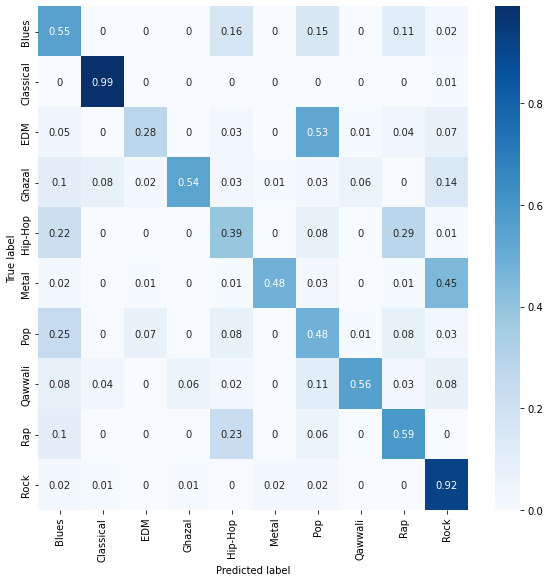

In [79]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Overall, you can see an improvement in the predictive capability using CNN. Qawwali and Ghazal are predicted with far greater accuracy even if other genres are being confounded due to their inherent similarity.